<h1><font color = 'darkblue',size =12><center>BANK MARKETING CAMPAIGN</font></h1>

_Runa Veigas_<br>
<right>runaveigas@gmail.com</right><br>

<h2><font color = 'green'>Objective</font></h2>

The classification goal is to predict if the client will subscribe a term deposit (variable y).


<h2><font color = 'green'><CENTER>INPUT VARIABLES</font></h2>

### bank client data:
1 - age (numeric) <br>
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')<br>
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
<br>4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
<br>5 - default: has credit in default? (categorical: 'no','yes','unknown')
<br>6 - housing: has housing loan? (categorical: 'no','yes','unknown')
<br>7 - loan: has personal loan? (categorical: 'no','yes','unknown')
### related with the last contact of the current campaign:
<br>8 - contact: contact communication type (categorical: 'cellular','telephone')
<br>9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
<br>10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
<br>11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
### other attributes:
<br>12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
<br>13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
<br>14 - previous: number of contacts performed before this campaign and for this client (numeric)
<br>15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
### social and economic context attributes
<br>16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
<br>17 - cons.price.idx: consumer price index - monthly indicator (numeric)
<br>18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
<br>19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
<br>20 - nr.employed: number of employees - quarterly indicator (numeric)

### Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')



In [1]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

In [28]:
df = pd.read_csv('bank-full.csv',sep = ';')

<IPython.core.display.Javascript object>

In [29]:
df.head()
df['default'] = df['default'].astype(object)
df['housing'] = df['housing'].astype(object)
df['loan'] = df['loan'].astype(object)
df['housing'] = df['housing'].astype(object)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [11]:
df.shape

(45211, 17)

### Missing Values

In [6]:
def nullValues(df):
    numMissing = df.isnull().sum()
    percentMissing = (100 * numMissing)/len(df)
    concatValues = pd.concat([numMissing,percentMissing],axis = 1)
    
    #Renaming and Sorting the percentage of missing values in non ascending order
    missingRenamed = concatValues.rename(columns = {0:"Missing Values", 1: "Percentage of Missing"})
    missingRenamedSorted = missingRenamed[missingRenamed.iloc[:,1]!=0].sort_values(by = 'Percentage of Missing',ascending = False).round(1) 
    print("Bank Data has totally {} coloumns out of which {} coloumns have missing values.".format
          (df.shape[1],missingRenamedSorted.shape[0]))
    return missingRenamedSorted

In [8]:
missingValues = nullValues(df)

<IPython.core.display.Javascript object>

Bank Data has totally 17 coloumns out of which 0 coloumns have missing values.


#### Visual Representation:

<IPython.core.display.Javascript object>

<AxesSubplot:>

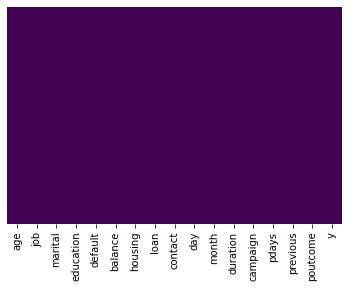

In [33]:
sns.heatmap(df.isnull(),yticklabels = False,cbar = False,cmap = 'viridis')

# DATA PREPROCESSING

In [31]:
from sklearn import preprocessing

In [32]:
count = 0

for col in df:
    if df[col].dtype == 'object':
        if len(list(df[col].unique())) <= 2:     
            le = preprocessing.LabelEncoder()
            df[col] = le.fit_transform(df[col])
            count += 1
            print (col)
            
print('%d columns were label encoded.' % count,'shape = ',df.shape)

default
housing
loan
y
4 columns were label encoded. shape =  (45211, 17)


And one-hot encoding the rest categorical columns,

In [33]:
df = pd.get_dummies(df)
print(df.shape)

<IPython.core.display.Javascript object>

(45211, 49)


In [38]:
df['y'].value_counts()

0    39922
1     5289
Name: y, dtype: int64

# MODELING

Now, for modeling I will be using two ensemble methods and comparing them.

i) Bootstrap Aggregrating or Bagging

ii) Boosting

## Bagging

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Creating a classification report function,

In [2]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))
        
    elif train==False:
        print("Test Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, clf.predict(X_test))))
        print("Classification Report: \n {}\n".format(classification_report(y_test, clf.predict(X_test))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, clf.predict(X_test)))) 

Conducting train test split.

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('y',axis=1),df['y'],test_size=0.15,random_state=101)

Freeing up the memory.

In [41]:
import gc

In [42]:
gc.collect()

102

Standardizing features by removing the mean and scaling to unit variance

In [43]:
from sklearn.preprocessing import StandardScaler

In [44]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test=sc.transform(X_test)

Oversampling only the training set using Synthetic Minority Oversampling Technique (SMOTE)

In [45]:
from imblearn.over_sampling import SMOTE

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

C:\Users\RUNA\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='y', ylabel='count'>

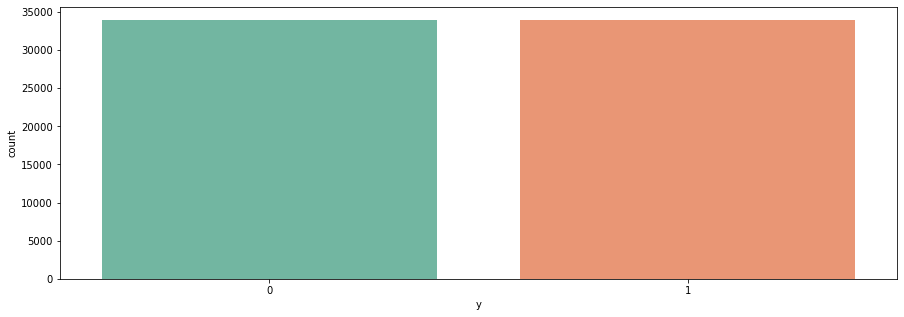

In [54]:
sm = SMOTE(random_state=12, sampling_strategy = 1.0)
x_train_r, y_train_r = sm.fit_sample(X_train, y_train)

plt.figure(figsize = (15,5))
sns.countplot(y_train_r,palette = 'Set2')

Now, I'll be trying out different models to get the best prediction score.

Creating a baseline for accuracy and recall using Logistic regression,

In [55]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(C = 0.0001,random_state=21)
log_reg.fit(x_train_r, y_train_r)

LogisticRegression(C=0.0001, random_state=21)

Precision = TP/ (TP+FP), when the model predict yes how likely it is actually correct?<br>
Recall = TP/ (TP+FN),When it is actually yes how often the model predicts it correctly<br>
Accuracy = TP+TN/(TP+TN+FP+FN),This is only accurate if the model is balanced. It will give inaccurate results if there is a class imbalance.

In [56]:
print_score(log_reg, x_train_r, y_train_r, X_test, y_test, train=False)

Test Result:

accuracy score: 0.8520

Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.86      0.91      5968
           1       0.44      0.79      0.56       814

    accuracy                           0.85      6782
   macro avg       0.70      0.82      0.74      6782
weighted avg       0.90      0.85      0.87      6782


Confusion Matrix: 
 [[5139  829]
 [ 175  639]]



Using Random Forest Classifier

In [58]:
clf_rf = RandomForestClassifier(n_estimators=40, random_state=21)
clf_rf.fit(x_train_r, y_train_r)

RandomForestClassifier(n_estimators=40, random_state=21)

In [59]:
print_score(clf_rf, x_train_r, y_train_r, X_test, y_test, train=False)

Test Result:

accuracy score: 0.8977

Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.95      0.94      5968
           1       0.58      0.54      0.56       814

    accuracy                           0.90      6782
   macro avg       0.76      0.74      0.75      6782
weighted avg       0.89      0.90      0.90      6782


Confusion Matrix: 
 [[5652  316]
 [ 378  436]]



Recall and Precision are not very high.

## Boosting

For boosting I will be using the LightGBM classifier (evalulation metric as AUC) along with Kfold cross validation.

In [61]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
from lightgbm import LGBMClassifier

Function to use LightGBM with Kfold cross validation,

In [62]:
def kfold_lightgbm(train_df, num_folds, stratified = False):
    print("Starting LightGBM. Train shape: {}".format(train_df.shape))
    
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=47)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=47)

    oof_preds = np.zeros(train_df.shape[0])

    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['y']]
    
      # Splitting the training set into folds for Cross Validation
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['y'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['y'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['y'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=32,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.04,
            reg_lambda=0.073,
            min_split_gain=0.0222415,
            min_child_weight=40,
            silent=-1,
            verbose=-1,
            )
      # Fitting the model and evaluating by AUC
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 1000, early_stopping_rounds= 200)
        print_score(clf, train_x, train_y, valid_x, valid_y, train=False)
        # Dataframe holding the different features and their importance
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        # Freeing up memory
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    display_importances(feature_importance_df)
    return feature_importance_df

Function for displaying the importance of the features,

In [63]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(15, 12))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')

Starting LightGBM. Train shape: (45211, 49)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[722]	training's auc: 0.949372	training's binary_logloss: 0.178298	valid_1's auc: 0.930503	valid_1's binary_logloss: 0.201088
Test Result:

accuracy score: 0.9068

Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.96      0.95     13325
           1       0.63      0.46      0.54      1746

    accuracy                           0.91     15071
   macro avg       0.78      0.71      0.74     15071
weighted avg       0.90      0.91      0.90     15071


Confusion Matrix: 
 [[12857   468]
 [  937   809]]



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.954416	training's binary_logloss: 0.170155	valid_1's auc: 0.931467	valid_1's binary_logloss: 0.203802
Early stopping, best iteration is:
[1077]	training's auc: 0.955478	training's binary_logloss: 0.168429	valid_1's auc: 0.9316	valid_1's binary_logloss: 0.203664
Test Result:

accuracy score: 0.9073

Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.97      0.95     13288
           1       0.65      0.47      0.54      1782

    accuracy                           0.91     15070
   macro avg       0.79      0.72      0.75     15070
weighted avg       0.90      0.91      0.90     15070


Confusion Matrix: 
 [[12838   450]
 [  947   835]]



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.953749	training's binary_logloss: 0.17106	valid_1's auc: 0.93321	valid_1's binary_logloss: 0.201059
Early stopping, best iteration is:
[1304]	training's auc: 0.956798	training's binary_logloss: 0.166335	valid_1's auc: 0.93346	valid_1's binary_logloss: 0.200886
Test Result:

accuracy score: 0.9061

Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.96      0.95     13309
           1       0.63      0.47      0.54      1761

    accuracy                           0.91     15070
   macro avg       0.78      0.72      0.74     15070
weighted avg       0.90      0.91      0.90     15070


Confusion Matrix: 
 [[12822   487]
 [  928   833]]



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

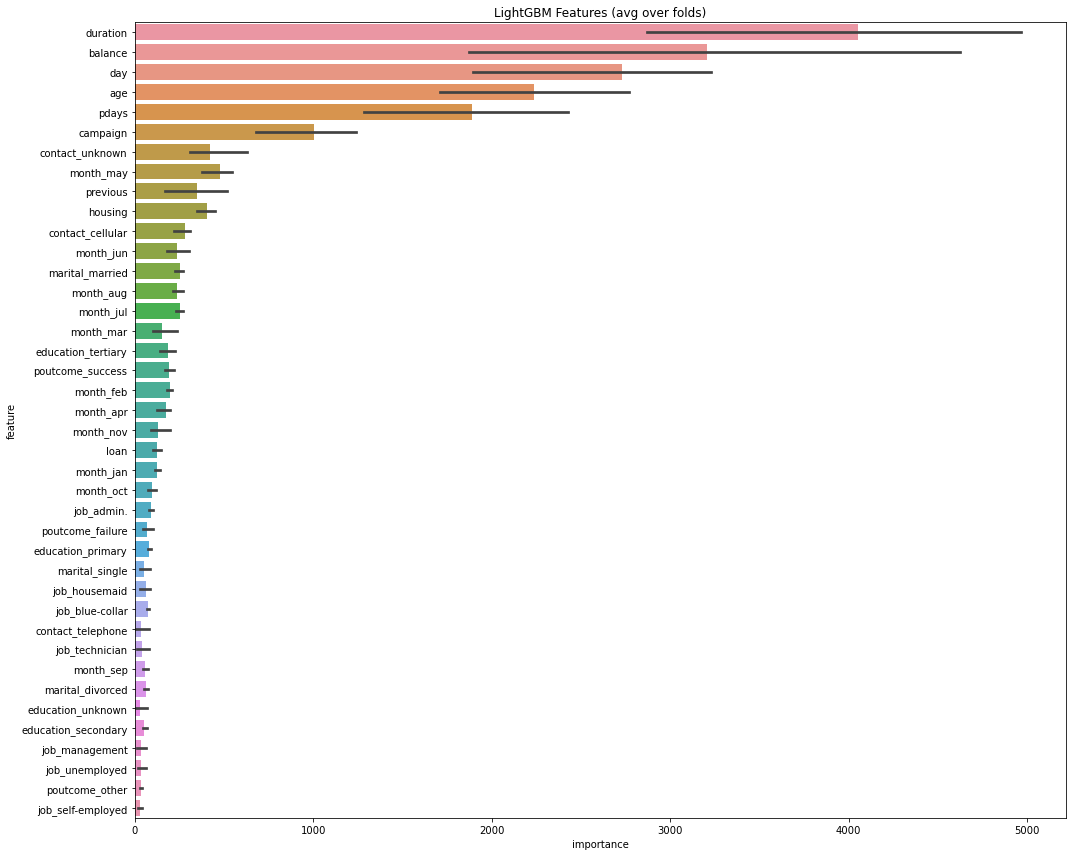

In [64]:
feat_importance = kfold_lightgbm(df, num_folds= 3, stratified= False)

As we can see, LightGBM had better precision score tha Random Forest though Random Forest has better recall score than LightGM.

However Accuracy is best for LightGM model